In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import warnings
import tensorflow as tf
from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Activation, Lambda, Add, concatenate, Reshape,DepthwiseConv2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras import initializers, regularizers, constraints
from keras.utils import conv_utils, layer_utils
from keras.utils.io_utils import HDF5Matrix
from keras.engine.topology import Layer
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras.applications import imagenet_utils
from keras.applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import keras
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import h5py
from sklearn.model_selection import train_test_split

%matplotlib inline
from matplotlib import pyplot as plt

# Own module
import sys
sys.path.append("../utils/")
from utils import smoothL1, relu6
#from layers import DepthwiseConv2D
INPUT_SHAPE = (256, 256, 3)
INPUT_IMG = (3,1920,1080)
OUTPUT_SIZE = 4
print(INPUT_SHAPE[0])

Using TensorFlow backend.


256


In [2]:
def facial_landmark_cnn(input_shape=INPUT_SHAPE, output_size=OUTPUT_SIZE):
    # Stage 1 #
    img_input = Input(shape=input_shape)
    
    ## Block 1 ##
    x = Conv2D(32, (3,3), strides=(1,1), name='S1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv1')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool1')(x)

    ## Block 2 ##
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv2')(x)
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv3')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool2')(x)

    ## Block 3 ##
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv4')(x)
    x = Conv2D(64, (3,3), strides=(1,1), name='S1_conv5')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv5')(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='S1_pool3')(x)
        
    ## Block 4 ##
    x = Conv2D(256, (3,3), strides=(1,1), name='S1_conv8')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name='S1_relu_conv8')(x)
    x = Dropout(0.2)(x)
    
    ## Block 5 ##
    x = Flatten(name='S1_flatten')(x)
    x = Dense(2048, activation='relu', name='S1_fc1')(x)
    x = Dense(output_size, activation=None, name='S1_predictions')(x)
    model = Model([img_input], x, name='facial_landmark_model')
    
    return model

In [3]:
# Data Import
x_data = HDF5Matrix('Tool.h5', 'image')
y_data = HDF5Matrix('Tool.h5','pts')

In [4]:
# Data Arrange
X = np.zeros([x_data.shape[0],x_data.shape[3],x_data.shape[2],x_data.shape[1]])
X_resized = np.zeros([x_data.shape[0],INPUT_SHAPE[0],INPUT_SHAPE[1],x_data.shape[1]])
Y = np.zeros([y_data.shape[0],y_data.shape[2]*y_data.shape[1]])
Y_sample = np.zeros([y_data.shape[0],y_data.shape[2],y_data.shape[1]])
print(X.shape)
print(Y.shape)

for j in range(0,x_data.shape[0]):
    temp = x_data[j]
    X[j,:,:,:] = np.transpose(temp)

temp2 = np.zeros([2,2])
for j in range(0,y_data.shape[0]):
    temp2[:,0] = y_data[j][0,:]*INPUT_SHAPE[0]/1920
    temp2[:,1] = y_data[j][1,:]*INPUT_SHAPE[1]/1080
    Y_sample[j] = temp2
    Y[j,:] = temp2.reshape(-1,OUTPUT_SIZE)
        
print(X.shape)
print(Y.shape)
X = np.array(X)
Y = np.array(Y)

(206, 1080, 1920, 3)
(206, 4)
(206, 1080, 1920, 3)
(206, 4)


In [5]:
# Data Resize
import scipy
i_height = INPUT_SHAPE[0]
i_width = INPUT_SHAPE[1]
for i in range(0,X.shape[0]):
    X_resized[i] = scipy.misc.imresize(X[i,:,:,:], (i_height, i_width,3))


C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


[[109.76666667 126.16296296]
 [112.36666667 131.4962963 ]]
[109.76666667 126.16296296 112.36666667 131.4962963 ]


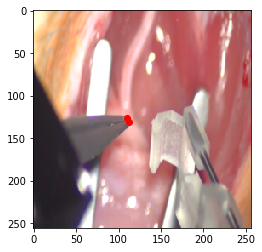

In [6]:
img_num = 3
plt.imshow(X_resized[img_num].astype('uint8'))
plt.scatter(Y_sample[img_num,:,0],Y_sample[img_num,:,1],c = [1,0,0])
# plt.scatter(y_data[img_num][0,:]/30,y_data[img_num][1,:]/16.875,c = [0,1,0])
print(Y_sample[img_num])
print(Y[img_num])

In [7]:
X_resized_norm = X_resized/255
Y_resized_norm = Y/INPUT_SHAPE[0]

In [8]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_resized_norm, Y_resized_norm, test_size=0.2)

In [9]:

print("Success of getting train / test dataset")
print("=======================================")
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)
print("=======================================")
print(X_train)
print(y_train)

Success of getting train / test dataset
X_train:  (164, 256, 256, 3)
y_train:  (164, 4)
X_test:  (42, 256, 256, 3)
y_test:  (42, 4)
[[[[1.         0.99607843 0.9254902 ]
   [1.         1.         0.92941176]
   [1.         1.         0.90980392]
   ...
   [0.68627451 0.47843137 0.49019608]
   [0.67843137 0.4745098  0.48627451]
   [0.6745098  0.47058824 0.48235294]]

  [[1.         1.         0.92941176]
   [1.         1.         0.9254902 ]
   [1.         1.         0.90980392]
   ...
   [0.68627451 0.47843137 0.49019608]
   [0.68235294 0.4745098  0.48627451]
   [0.67843137 0.47058824 0.48235294]]

  [[1.         1.         0.90980392]
   [1.         1.         0.90588235]
   [1.         1.         0.89411765]
   ...
   [0.68235294 0.46666667 0.48235294]
   [0.67843137 0.4627451  0.47843137]
   [0.6745098  0.45882353 0.4745098 ]]

  ...

  [[0.18039216 0.15294118 0.25098039]
   [0.16862745 0.1254902  0.20784314]
   [0.1372549  0.10588235 0.17254902]
   ...
   [0.34901961 0.22745098 0.2

In [11]:
model = facial_landmark_cnn(X_train.shape[1:4], y_train.shape[1])
model.compile(loss=smoothL1, optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['mape'])
print(model.summary())
# checkpoint
#filepath="./basic_checkpoints/smooth_L1-{epoch:02d}-{val_mean_absolute_percentage_error:.5f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
# history = model.fit(X_train, y_train, batch_size=64, epochs=100, shuffle=True,\
#                     verbose=1, validation_data=(X_test, y_test), callbacks=callbacks_list)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=True,\
                    verbose=1, validation_data=(X_test, y_test))
# Save model
model.save("landmark_dnn.h5")
print("=======================================")
print("Save Final Model")
print("=======================================")
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
S1_conv1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
S1_relu_conv1 (Activation)   (None, 254, 254, 32)      0         
_________________________________________________________________
S1_pool1 (MaxPooling2D)      (None, 127, 127, 32)      0         
_________________________________________________________________
S1_conv2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 125, 125, 64)      256       
__________

ResourceExhaustedError: OOM when allocating tensor of shape [173056,2048] and type float
	 [[Node: training_1/Adam/zeros_24 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [173056,2048] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training_1/Adam/zeros_24', defined at:
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-04744da01602>", line 11, in <module>
    history = model.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=True,                    verbose=1, validation_data=(X_test, y_test))
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\engine\training.py", line 1008, in fit
    self._make_train_function()
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\engine\training.py", line 498, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\optimizers.py", line 482, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\optimizers.py", line 482, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\keras\backend\tensorflow_backend.py", line 700, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1551, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2794, in fill
    "Fill", dims=dims, value=value, name=name)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\HERO\Anaconda3\envs\shn\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [173056,2048] and type float
	 [[Node: training_1/Adam/zeros_24 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [173056,2048] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


In [ ]:
img_num = 100
img_test = X_train[img_num]
pts = model.predict(X_train)
pts = pts[img_num,:]
pts = pts.reshape(-1,2)

plt.imshow(img_test)
plt.scatter(pts[:,0]*INPUT_SHAPE[0], pts[:,1]*INPUT_SHAPE[0], c = [1,0,0])
plt.show()
print(pts)

In [1]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x":(1, 5)})
])
